In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report, precision_recall_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight

In [2]:
# Define dataset details
datasets = [
    {
        "name": "wisconsin data",
        "path": "C:\\Users\\arpitha_work\\Downloads\\TRU MSCDS\\Sem2\\DS Seminar\\Project 1\\Datasets\\wisconsin data.csv",
        "features_numerical": [
            "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean", 
            "compactness_mean", "concavity_mean", "concave points_mean", "symmetry_mean", 
            "fractal_dimension_mean", "radius_se", "texture_se", "perimeter_se", "area_se", 
            "smoothness_se", "compactness_se", "concavity_se", "concave points_se", "symmetry_se", 
            "fractal_dimension_se", "radius_worst", "texture_worst", "perimeter_worst", 
            "area_worst", "smoothness_worst", "compactness_worst", "concavity_worst", 
            "concave points_worst", "symmetry_worst", "fractal_dimension_worst"
        ],
        "features_categorical": [],
        "target": "diagnosis"
    },
    {
        "name": "breast-cancer-dataset",
        "path": "C:\\Users\\arpitha_work\\Downloads\\TRU MSCDS\\Sem2\\DS Seminar\\Project 1\\Datasets\\breast-cancer-dataset.csv",
        "features_numerical": ["Year", "Age", "Tumor Size (cm)", "Inv-Nodes"],
        "features_categorical": ["Menopause", "Breast", "Metastasis", "Breast Quadrant", "History"],
        "target": "Diagnosis Result"
    },
    {
        "name": "BRCA",
        "path": "C:\\Users\\arpitha_work\\Downloads\\TRU MSCDS\\Sem2\\DS Seminar\\Project 1\\Datasets\\BRCA.csv",
        "features_numerical": ["Age", "Protein1", "Protein2", "Protein3", "Protein4"],
        "features_categorical": ["Gender", "Tumour_Stage", "Histology", "ER status", "PR status", "HER2 status", "Surgery_type"],
        "target": "Patient_Status"
    },
    {
        "name": "german bs data",
        "path": "C:\\Users\\arpitha_work\\Downloads\\TRU MSCDS\\Sem2\\DS Seminar\\Project 1\\Datasets\\german bs data.csv",
        "features_numerical": ["age", "size", "grade", "nodes", "pgr", "er", "rfstime"],
        "features_categorical": ["meno", "hormon"],
        "target": "status"
    },
    {
        "name": "seer data",
        "path": "C:\\Users\\arpitha_work\\Downloads\\TRU MSCDS\\Sem2\\DS Seminar\\Project 1\\Datasets\\seer data.csv",
        "features_numerical": ["Age", "Survival Months", "Regional Node Examined"],
        "features_categorical": [
            "Race", "Marital Status", "T Stage ", "N Stage", "6th Stage", "differentiate", 
            "Grade", "A Stage", "Tumor Size", "Estrogen Status", "Progesterone Status", 
            "Reginol Node Positive"
        ],
        "target": "Status"
    }
]



In [3]:
def preprocess_dataset(dataset):
    print(f"Processing dataset: {dataset['name']}")
    df = pd.read_csv(dataset['path'])
    
    # Verify that all specified columns exist in the dataset
    missing_numerical = [col for col in dataset["features_numerical"] if col not in df.columns]
    missing_categorical = [col for col in dataset["features_categorical"] if col not in df.columns]
    
    if missing_numerical or missing_categorical:
        raise ValueError(
            f"Missing columns in dataset {dataset['name']}: "
            f"Numerical: {missing_numerical}, Categorical: {missing_categorical}"
        )
    
    # Clean numerical columns: replace non-numeric values with NaN
    for col in dataset["features_numerical"]:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, invalid values become NaN
    
    # Drop rows with missing values in numerical columns
    df.dropna(subset=dataset["features_numerical"], inplace=True)
    
    # Extract numerical and categorical features
    X_num = df[dataset["features_numerical"]]
    X_cat = df[dataset["features_categorical"]] if dataset["features_categorical"] else pd.DataFrame()
    y = df[dataset["target"]]

    # Encode categorical variables if they exist
    if not X_cat.empty:
        X_cat = pd.get_dummies(X_cat, drop_first=True)
    
    # Encode target variable if it's categorical
    if y.dtype == 'object':
        le = LabelEncoder()
        y = le.fit_transform(y)

    # Combine features
    X = pd.concat([X_num, X_cat], axis=1) if not X_cat.empty else X_num

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Scale numerical features (keeping them as DataFrames)
    scaler = StandardScaler()
    X_train[dataset["features_numerical"]] = scaler.fit_transform(X_train[dataset["features_numerical"]])
    X_test[dataset["features_numerical"]] = scaler.transform(X_test[dataset["features_numerical"]])

    # Convert all data to float32 for TensorFlow compatibility
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)

    return X_train, X_test, y_train, y_test

In [4]:
def build_neural_network(input_shape, num_classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy' if num_classes > 1 else 'binary_crossentropy', 
                  metrics=['accuracy'])
    return model

In [5]:
def handle_class_imbalance(X_train, y_train):
    # Apply SMOTE for oversampling
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Calculate class weights
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
    class_weights = dict(enumerate(class_weights))
    
    return X_train_resampled, y_train_resampled, class_weights

In [6]:
results = []
binary_classification_datasets = []

for dataset in datasets:
    print(f"\n{'='*50}\nTraining on dataset: {dataset['name']}\n{'='*50}")
    X_train, X_test, y_train, y_test = preprocess_dataset(dataset)
    
    # Handle class imbalance
    X_train_resampled, y_train_resampled, class_weights = handle_class_imbalance(X_train, y_train)
    
    # Determine the number of classes
    num_classes = len(np.unique(y_train_resampled))
    
    # Build and train the neural network
    input_shape = X_train_resampled.shape[1]
    nn_model = build_neural_network(input_shape, num_classes)
    
    # Convert y_train and y_test to one-hot encoding for multiclass classification
    if num_classes > 1:
        y_train_resampled = pd.get_dummies(y_train_resampled).values
        y_test = pd.get_dummies(y_test).values
    else:
        binary_classification_datasets.append(dataset["name"])  # Track binary datasets
    
    # Train the model with class weights
    history = nn_model.fit(
        X_train_resampled, y_train_resampled, 
        epochs=50, 
        batch_size=32, 
        validation_split=0.2, 
        verbose=1, 
        class_weight=class_weights
    )
    
    # Evaluate the neural network
    y_pred_nn = nn_model.predict(X_test)
    
    if num_classes > 1:
        # Multiclass classification
        y_pred_labels = np.argmax(y_pred_nn, axis=1)  # Predicted class labels
        y_test_labels = np.argmax(y_test, axis=1)  # True class labels
    else:
        # Binary classification
        y_pred_labels = (y_pred_nn > 0.5).astype(int)  # Predicted class labels
        y_test_labels = y_test  # True class labels
    
    # Calculate accuracy
    nn_acc = accuracy_score(y_test_labels, y_pred_labels)
    
    # Calculate ROC-AUC
    if num_classes > 1:
        # Multiclass ROC-AUC
        nn_roc_auc = roc_auc_score(y_test, y_pred_nn, multi_class='ovr', average='weighted')
    else:
        # Binary ROC-AUC
        nn_roc_auc = roc_auc_score(y_test_labels, y_pred_nn)
    
    # Store results
    results.append({
        "dataset": dataset["name"],
        "accuracy": nn_acc,
        "roc_auc": nn_roc_auc
    })
    
    print(f"Model Accuracy: {nn_acc}")
    print(f"ROC-AUC: {nn_roc_auc}")


Training on dataset: wisconsin data
Processing dataset: wisconsin data


C:\Users\arpitha_work\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.6616 - loss: 0.6141 - val_accuracy: 0.9100 - val_loss: 0.4205
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9281 - loss: 0.2794 - val_accuracy: 0.9300 - val_loss: 0.2347
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9383 - loss: 0.1783 - val_accuracy: 0.9700 - val_loss: 0.1268
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9718 - loss: 0.1054 - val_accuracy: 0.9700 - val_loss: 0.0871
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9733 - loss: 0.0939 - val_accuracy: 0.9800 - val_loss: 0.0612
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9790 - loss: 0.0831 - val_accuracy: 0.9800 - val_loss: 0.0490
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9706 - loss: 0.0902 - val_accuracy: 0.9800 - val_loss: 0.0461
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9758 - loss: 0.0765 - val_accuracy: 0.9800 - v

C:\Users\arpitha_work\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.6336 - loss: 0.6584 - val_accuracy: 0.7941 - val_loss: 0.6398
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7924 - loss: 0.5546 - val_accuracy: 0.8235 - val_loss: 0.6150
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8702 - loss: 0.4503 - val_accuracy: 0.8235 - val_loss: 0.6203
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8650 - loss: 0.4117 - val_accuracy: 0.8235 - val_loss: 0.6574
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9001 - loss: 0.3405 - val_accuracy: 0.8235 - val_loss: 0.6935
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8962 - loss: 0.3014 - val_accuracy: 0.8235 - val_loss: 0.6980
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9046 - loss: 0.2840 - val_accuracy: 0.8235 - val_loss: 0.6217
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9004 - loss: 0.2495 - val_accuracy: 0.8235 - val_loss: 0.5435

C:\Users\arpitha_work\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.3791 - loss: 1.0882 - val_accuracy: 0.0000e+00 - val_loss: 1.5514
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4714 - loss: 1.0283 - val_accuracy: 0.0000e+00 - val_loss: 1.7573
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4863 - loss: 1.0099 - val_accuracy: 0.0000e+00 - val_loss: 1.6423
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4996 - loss: 0.9949 - val_accuracy: 0.0000e+00 - val_loss: 1.5497
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5609 - loss: 0.9297 - val_accuracy: 0.0000e+00 - val_loss: 1.5828
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5512 - loss: 0.9186 - val_accuracy: 0.0000e+00 - val_loss: 1.5071
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5595 - loss: 0.9042 - val_accuracy: 0.0000e+00 - val_loss: 1.4815
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5204 - loss: 0.9018

C:\Users\arpitha_work\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.5103 - loss: 0.6898 - val_accuracy: 0.4220 - val_loss: 0.7254
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6477 - loss: 0.6227 - val_accuracy: 0.6330 - val_loss: 0.6556
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7367 - loss: 0.5595 - val_accuracy: 0.7064 - val_loss: 0.6187
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6945 - loss: 0.5525 - val_accuracy: 0.7248 - val_loss: 0.6079
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7280 - loss: 0.5588 - val_accuracy: 0.7339 - val_loss: 0.6035
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7642 - loss: 0.4975 - val_accuracy: 0.7248 - val_loss: 0.5647
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7421 - loss: 0.5500 - val_accuracy: 0.7064 - val_loss: 0.5458
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7189 - loss: 0.5569 - val_accuracy: 0.7339 - v

C:\Users\arpitha_work\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5497 - loss: 0.9752 - val_accuracy: 0.3124 - val_loss: 0.7478
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6548 - loss: 0.6582 - val_accuracy: 0.6646 - val_loss: 0.6376
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7287 - loss: 0.5697 - val_accuracy: 0.7505 - val_loss: 0.5466
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7524 - loss: 0.5151 - val_accuracy: 0.7201 - val_loss: 0.6132
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7786 - loss: 0.4785 - val_accuracy: 0.7034 - val_loss: 0.6067
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7874 - loss: 0.4606 - val_accuracy: 0.7002 - val_loss: 0.6408
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8022 - loss: 0.4448 - val_accuracy: 0.7757 - val_loss: 0.4662
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7966 - loss: 0.4432 - val_accuracy: 0

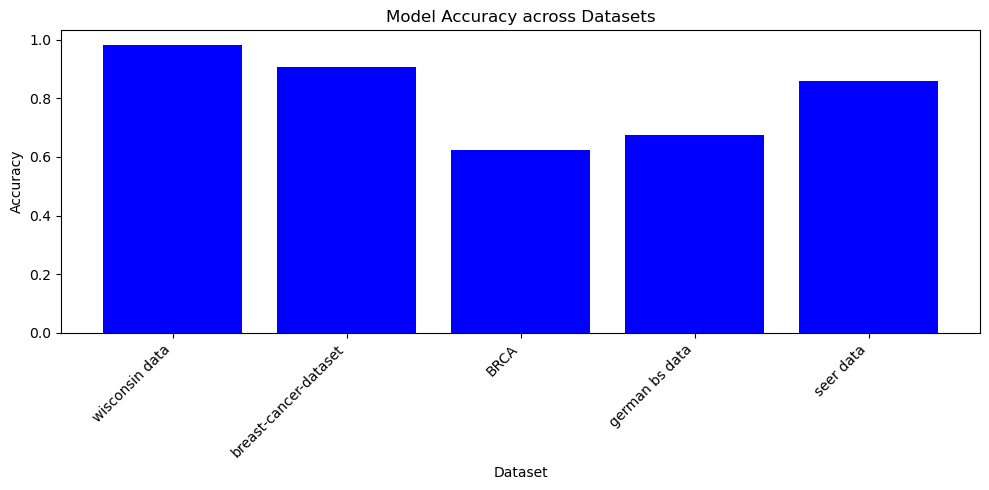

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Plot Accuracy for all datasets
dataset_names = [result["dataset"] for result in results]
accuracies = [result["accuracy"] for result in results]

plt.figure(figsize=(10, 5))
plt.bar(dataset_names, accuracies, color='blue')
plt.xlabel("Dataset")
plt.ylabel("Accuracy")
plt.title("Model Accuracy across Datasets")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [8]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Assuming 'results' contains your dataset and accuracy information
dataset_names = [result["dataset"] for result in results]
accuracies = [result["accuracy"] for result in results]

# Create the bar plot using Plotly
fig = go.Figure(data=[go.Bar(x=dataset_names, y=accuracies, marker=dict(color='blue'))])

# Add labels and title
fig.update_layout(
    title="Model Accuracy across Datasets",
    xaxis_title="Dataset",
    yaxis_title="Accuracy",
    xaxis_tickangle=-45
)

# Save the plot as an HTML file
html_file_path = 'model_accuracy_plot.html'
fig.write_html(html_file_path)

# Print the file path to confirm where it's saved
print(f"Plot saved as HTML file at: {html_file_path}")


Plot saved as HTML file at: model_accuracy_plot.html
